**Importing Libraries and Data**

In [1]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR,LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from IPython.display import display
from sklearn import metrics
import feather
import pandas as pd
import numpy as np
import seaborn as sns
from pdpbox import pdp
from plotnine import *


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Loading** Data

In [0]:
Path = '/content/drive/My Drive/Train.csv'
df_raw = pd.read_csv(f'{Path}', low_memory=False, parse_dates=["saledate"])

In [0]:
def display_all(df):
  with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
    display(df)

Displaying last five rows of data with features as rows

In [5]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


Kaggle stated us what metric to use: RMSLE (root mean squared log error) between the actual and predicted
auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

**Data Preprocessing**

This dataset contains a mix of continuous and categorical variables.
The following method extracts particular date fields from a complete datetime for the purpose of constructing
categoricals.

In [0]:
add_datepart(df_raw, 'saledate')

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric
coding required for a random forest. Therefore we call train_cats to convert strings to pandas
categories.

In [0]:
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a
model.

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent
variable into a separate variable.

In [0]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [10]:
total_rows = df.count
df.describe()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
count,4.011250e+05,4.011250e+05,401125.000000,401125.000000,401125.000000,401125.000000,4.011250e+05,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.00000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,4.011250e+05
mean,1.919713e+06,1.217903e+06,6889.702980,134.665810,6.327332,1899.156901,1.230726e+03,-0.623898,1673.709485,559.165442,36.685036,9.192686,12.233433,1.818219,32.262222,23.508318,3.725524,3.725524,0.809299,3.605195,0.513192,0.422315,0.566736,0.319010,3.372502,0.207060,0.064184,0.235228,0.178436,0.066067,4.253801,0.07722,0.552434,0.094088,0.090179,3.059847,1.511791,0.115889,0.115199,0.321483,0.458792,4.311895,6.535564,0.685153,0.516719,0.319479,0.196178,1.278128,1.132009,0.683189,0.344987,2004.095728,6.407035,26.179864,16.110402,2.600975,179.977581,1.091433e+09
std,9.090215e+05,4.409920e+05,6221.777842,8.962237,16.575066,291.797469,1.654290e+04,0.870291,1263.331163,469.310266,38.228243,27.006859,29.041950,2.107830,22.596618,15.732898,1.725772,1.725772,1.436850,2.220353,0.564375,0.873469,0.822794,0.678752,3.764052,0.428657,0.250385,1.025710,0.697879,0.260948,4.809368,0.31616,0.988317,0.384207,0.382552,5.950781,1.450320,0.342865,0.340769,0.926401,0.819459,7.741894,11.923308,1.226899,0.912594,0.659002,0.397231,2.649002,2.307099,1.501999,0.755775,5.754190,3.424575,14.788059,8.427322,1.405763,103.559930,1.816977e+08
min,1.139246e+06,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1989.000000,1.000000,1.000000,1.000000,0.000000,2.000000,6.009984e+08
25%,1.418371e+06,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00,-1.000000,631.000000,206.000000,0.000000,0.000000,0.000000,0.000000,11.000000,9.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,3.000000,13.000000,9.000000,2.000000,84.000000,9.708768e+08
50%,1.639422e+06,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00,-1.000000,1395.000000,406.000000,29.000000,0.000000,0.000000,0.000000,35.000000,22.000000,4.000000,4.000000,0.000000,3.000000,0.00

Displaying the preprocessed data

In [11]:
display_all(df.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,0,0,0,0,0
UsageBand,-1,-1,-1,-1,-1
fiModelDesc,657,657,657,483,483
fiBaseModel,207,207,207,159,159


**Splitting** data into train and validation set

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df)-n_valid

We now define a function which will print the score of a model in the given format:

[rmse of X_train, rmse of X_valid, R Square of X_train, R Square of X_Valid]

In [0]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
  res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
    m.score(X_train, y_train), m.score(X_valid, y_valid)]
  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
  print(res)

**Comparing different models**

For comparison of various model purpose we will take subset of dataset

In [0]:
df_comp = df_raw.head(20000)
df_c, y_c, nas = proc_df(df_comp, 'SalePrice')

In [0]:
X_train, X_valid = split_vals(df_c, 4000)
y_train, y_valid = split_vals(y_c, 4000)

Linear Regression

In [16]:
regr = LinearRegression()
regr.fit(X_train,y_train)
print_score(regr)

[0.43257806684632827, 0.5020256357271727, 0.6139402296247648, 0.492991383796476]


KNN Regressor

In [17]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
print_score(neigh)

[0.4324542751387735, 0.8019109868756249, 0.6141611569608169, -0.2936472742708758]


SVR(Support Vector regressor)

In [18]:
regr = SVR()
regr.fit(X_train, y_train)
print_score(regr)

[0.6960947371159066, 0.7052773777473924, 0.0003171133719986896, -0.0006528989416976216]


Random Forest

In [19]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
m.fit(X_train, y_train)
print_score(m)

[0.12724441852266474, 0.30195612965531926, 0.9665956488841599, 0.8165780734902155]


Compairing Different Models

In [20]:
def compare(model):
    m=model
    m.fit(X_train, y_train)
    pred=m.predict(X_valid)
    
    # Calculating various metrics
    RMSLE_Train.append(rmse(m.predict(X_train), y_train))
    RMSLE_Valid.append(rmse(m.predict(X_valid), y_valid))
    RSquaredTrain.append(m.score(X_train, y_train))
    RSquaredValid.append(m.score(X_valid, y_valid))  


RMSLE_Train=[]
RMSLE_Valid=[]
RSquaredTrain=[]
RSquaredValid=[]
models=[LinearRegression(),KNeighborsRegressor(n_neighbors=2),SVR(),RandomForestRegressor(n_jobs=-1, n_estimators=10)]
model_names=['linearRegression','KNeighborsRegressor','Support Vector Regressor','RandomForestRegressor']

for model in range(len(models)):
    compare(models[model])
    
d={'Modelling Algo':model_names,'RMSLE_Train':RMSLE_Train,'RMSLE_Valid':RMSLE_Valid,'RSquaredTrain':RSquaredTrain,'RSquaredValid':RSquaredValid}
met_df=pd.DataFrame(d)
met_df

,Modelling Algo,RMSLE_Train,RMSLE_Valid,RSquaredTrain,RSquaredValid
0,linearRegression,0.432578,0.502026,0.613940,0.492991
1,KNeighborsRegressor,0.432454,0.801911,0.614161,-0.293647
2,Support Vector Regressor,0.696095,0.705277,0.000317,-0.000653
3,RandomForestRegressor,0.127467,0.313952,0.966479,0.801715


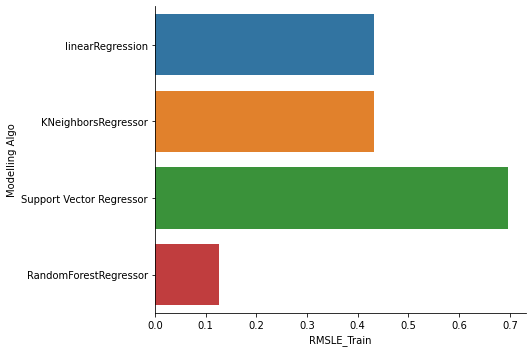

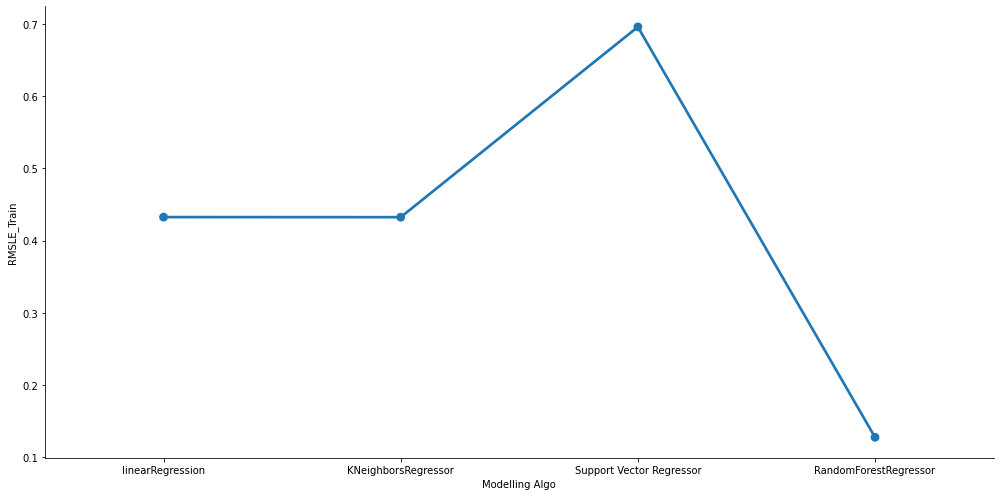

In [21]:
def comp_models(met_df,metric):
    sns.catplot(data=met_df,x=metric,y='Modelling Algo',height=5,aspect=1.5,kind='bar')
    sns.catplot(data=met_df,y=metric,x='Modelling Algo',height=7,aspect=2,kind='point')

comp_models(met_df,'RMSLE_Train')

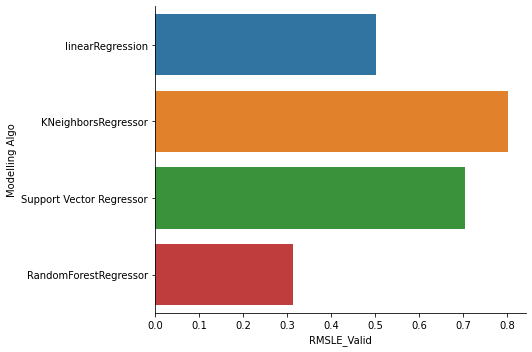

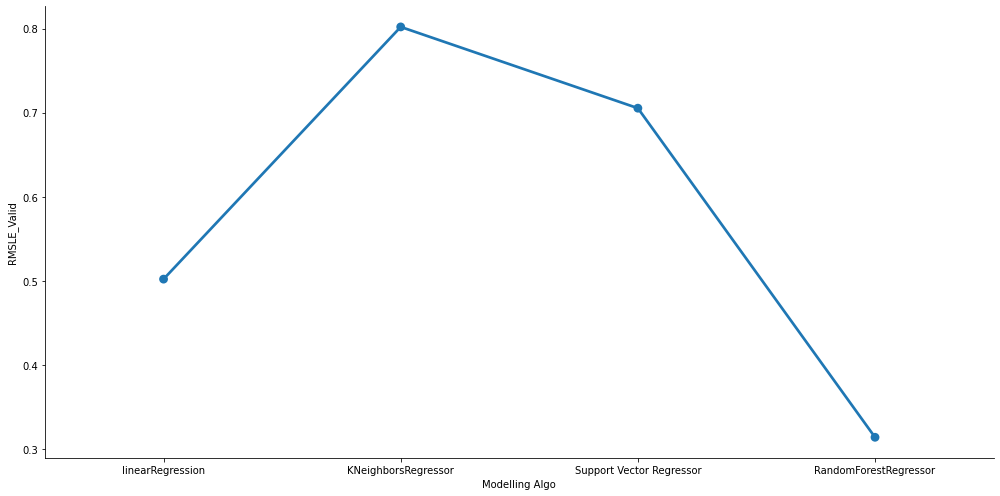

In [22]:
comp_models(met_df,'RMSLE_Valid')

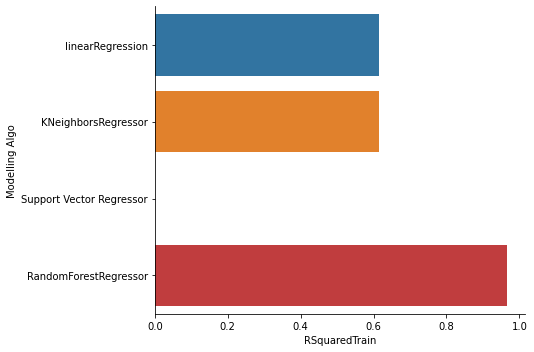

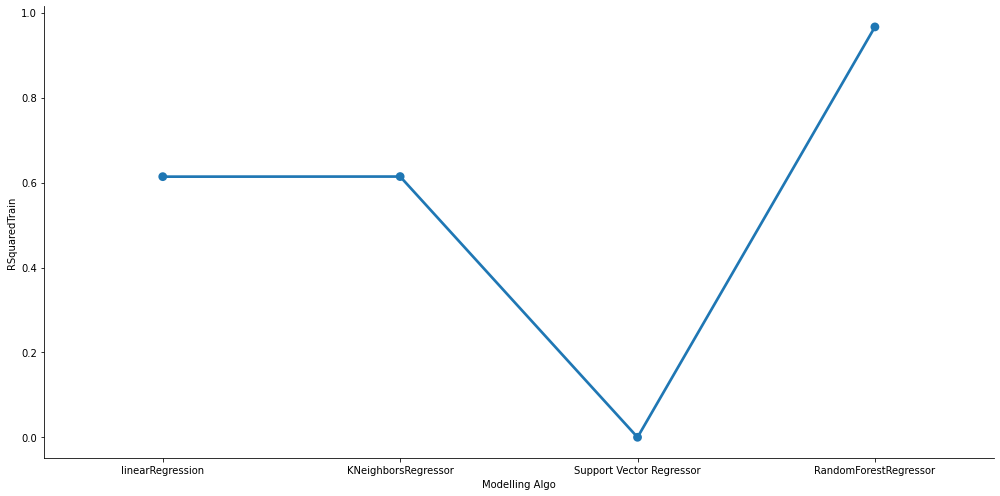

In [23]:
comp_models(met_df,'RSquaredTrain')

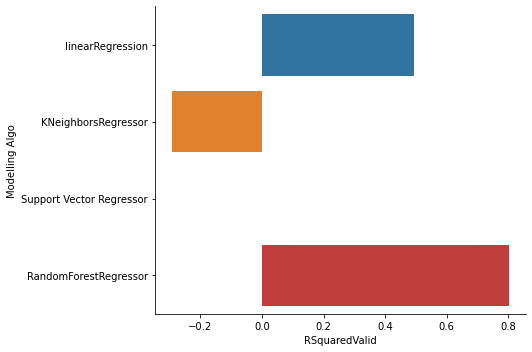

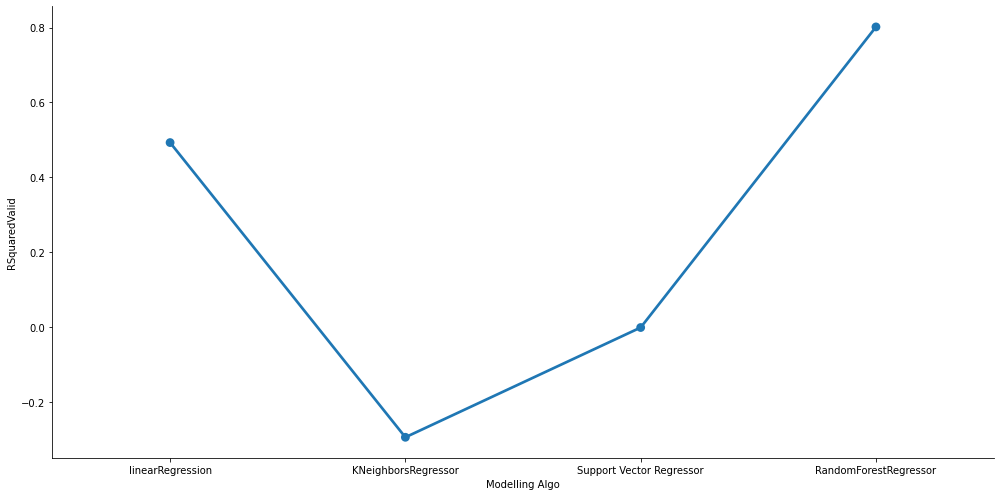

In [24]:
comp_models(met_df,'RSquaredValid')

We choose random Forest because of its metrics score

As evident, the model is badly overfitting.

**Hyperparameters Tuning**

Now, Switching back to full dataset

In [0]:
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df, n_trn)

**Selecting Optimal Value For n_estimators**

In [26]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=20, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.08279998247213637, 0.24318776123554595, 0.9856716785626002, 0.894383589512806, 0.8726826147412714]


In [27]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07829407916911037, 0.23715618908022415, 0.9871887157436764, 0.8995576419636772, 0.9084688714787899]


In [28]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=80, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07618766181208282, 0.23545940105392146, 0.9878687901107978, 0.9009897758088223, 0.9119868935092857]


In [29]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=160, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07503395276317608, 0.23397158119486938, 0.9882334138964082, 0.9022370733744284, 0.9140180429734575]


As of now we'll use n_estimators=40 even though we are getting better results with
n_estimators=80 in order to save time.

**Selecting Optimal Value For min_samples_leaf**

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with
min_samples_leaf ) that we require some minimum number of rows in every leaf node. This has two
benefits:
 
*   There are less decision rules for each leaf node; simpler models should generalize better

*   The predictions are made by averaging more rows in the leaf node, resulting in less volatility



In [30]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1151357057202036, 0.23322223093635314, 0.9722952088455544, 0.9028622891352919, 0.9084006667051903]


In [31]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14970167569622828, 0.23434322390810214, 0.9531630992673342, 0.9019262515654998, 0.9062408553048839]


As evident min_samples_leaf=3 is optimal

**Selecting Optimal Value For max_features**

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each
tree, but to also using a sample of columns for each split. We do this by specifying max_features , which
is the proportion of features to randomly select from at each split.

In [32]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11917177573415953, 0.22864399875391267, 0.9703187868735494, 0.9066385500795628, 0.9114515229182001]


In [33]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.15760511301601338, 0.2611300628391346, 0.9480870831334952, 0.8782239955423725, 0.8952432126457209]


In [34]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='log2', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.17590958027713147, 0.2778804427499844, 0.935328369451204, 0.8621001041011336, 0.8832080591360765]


In [35]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.7,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11590542273957793, 0.22815173736164907, 0.9719235408096514, 0.9070401242686743, 0.9116415324955893]


As evident max_features=0.5 is optimal

**Feature Engineering**

Feature engineering is the process of using domain knowledge of the data to create features that make
machine learning algorithms work.

In [0]:
set_rf_samples(50000)

In [37]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11913536831644725, 0.22800071182663156, 0.970336919543835, 0.9071631535162475]


We now print the ten most important features for building the model. The feature importance of every feature
is calculated by randomly shuffling the values of that feature and measuring how badly it affects the score of
our model.

In [38]:
fi = rf_feat_importance(m, df)
fi[:10]

,cols,imp
5,YearMade,0.165521
37,Coupler_System,0.115125
14,fiProductClassDesc,0.088494
13,ProductSize,0.085468
2,ModelID,0.057239
63,saleElapsed,0.053643
38,Grouser_Tracks,0.051039
10,fiSecondaryDesc,0.050237
39,Hydraulics_Flow,0.035648
8,fiModelDesc,0.034216


In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

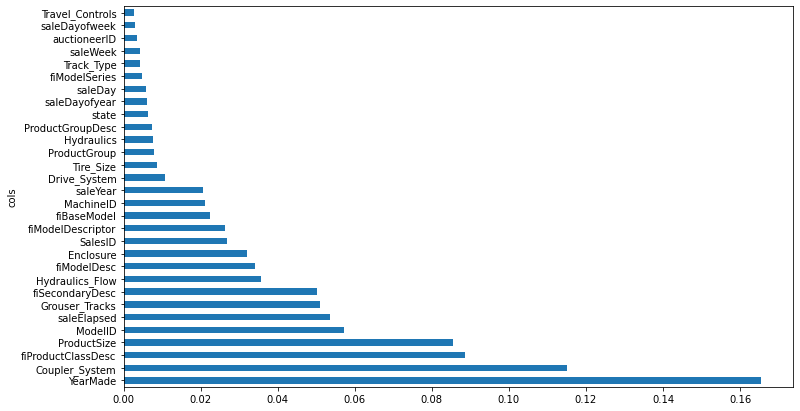

In [40]:
plot_fi(fi[:30]);

We now remove any feature whose feature importance is less that 0.005

In [41]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [0]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [43]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.12412506524029852, 0.2257745166878453, 0.967800153184738, 0.9089672177154068]


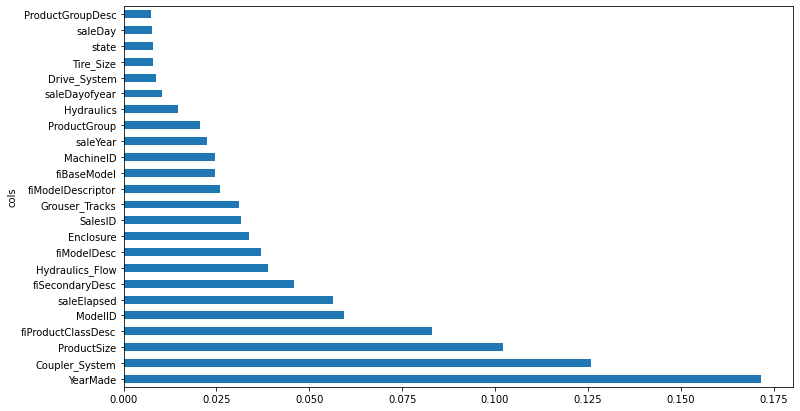

In [44]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

**Removing Redundant Features**

In [0]:
  from scipy.cluster import hierarchy as hc

The cell below will calculate the Spearman's rank correlation coefficient between every feature and plot it
in a nice readable format. Features which are close to each other in the figure are closely related

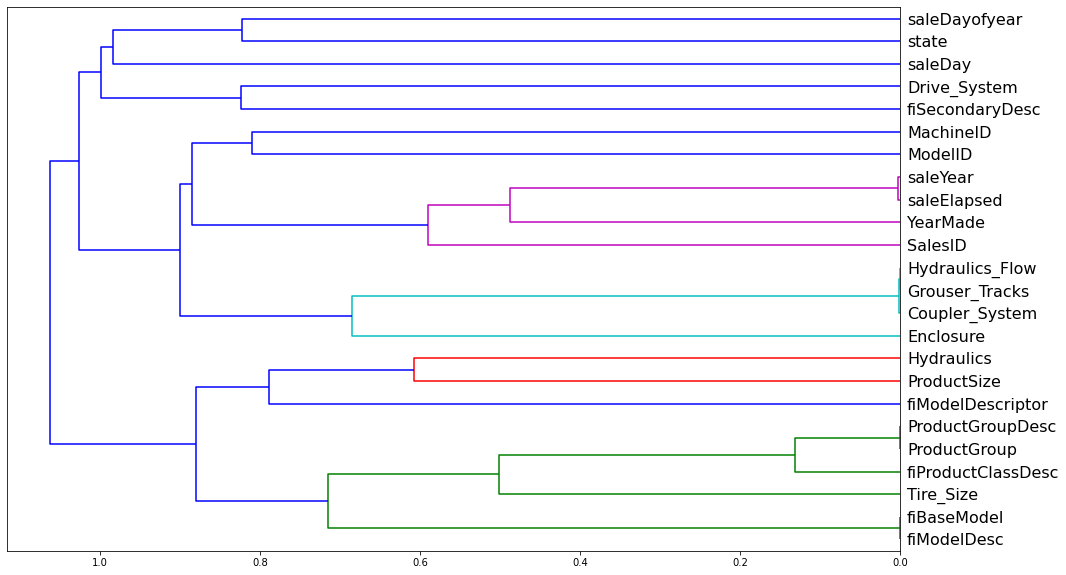

In [46]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the
accuracy.

In [0]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
  x, _ = split_vals(df, n_trn)
  m.fit(x, y_train)
  return m.oob_score_

Here's our baseline.

In [48]:
get_oob(df_keep)

0.906453831841733

Now we try removing each variable one at a time.

In [49]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System', 'Hydraulics_Flow'):
  print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.9057323973673567
saleElapsed 0.9039322590649165
fiModelDesc 0.9059041337618465
fiBaseModel 0.9055354259167705
Grouser_Tracks 0.9062275858838619
Coupler_System 0.9065775886360241
Hydraulics_Flow 0.906928451965702


Now we'll remove ['saleYear', 'fiBaseModel', 'Coupler_System', 'Hydraulics_Flow']

In [50]:
to_drop = ['saleYear', 'fiBaseModel', 'Coupler_System', 'Hydraulics_Flow']
get_oob(df_keep.drop(to_drop, axis=1))

0.9051597057115035

In [0]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
reset_rf_samples()

In [53]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12438847848062151, 0.2267646473999278, 0.9676633417210881, 0.9081670211627544, 0.9099227991075711]


**Analysing The Model Till Now**

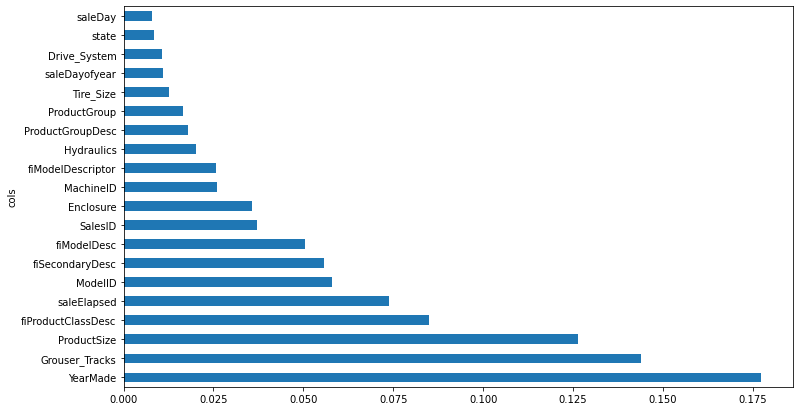

In [54]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Here we plot a scatter plot between 'YearMade', 'saleElapsed' to understand more about the data

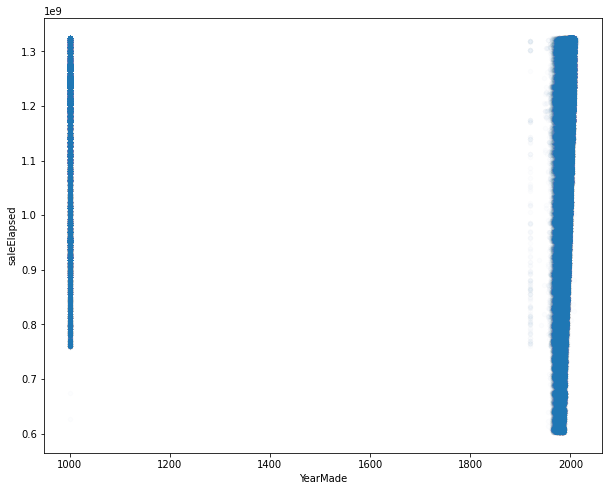

In [55]:
df_keep.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

**As seen in the figure above bulldozers made around or 1950 have YearMade = 1000 .**

In [0]:
df_keep.YearMade[df_keep.YearMade<1950] = 1950
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
x_all = get_sample(X_train[X_train.YearMade>1930], 500)

In [0]:
def plot_pdp(feat, clusters=None, feat_name=None):
  feat_name = feat_name or feat
  p = pdp.pdp_isolate(m, x_all, x_all.columns, feat)
  return pdp.pdp_plot(p, feat_name, plot_lines=True,cluster=clusters is not None,n_cluster_centers=clusters)

We now plot how YearMade is related to SalesPrice . The plot is a partial dependence plot which is
unaffected by any outside correlation.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


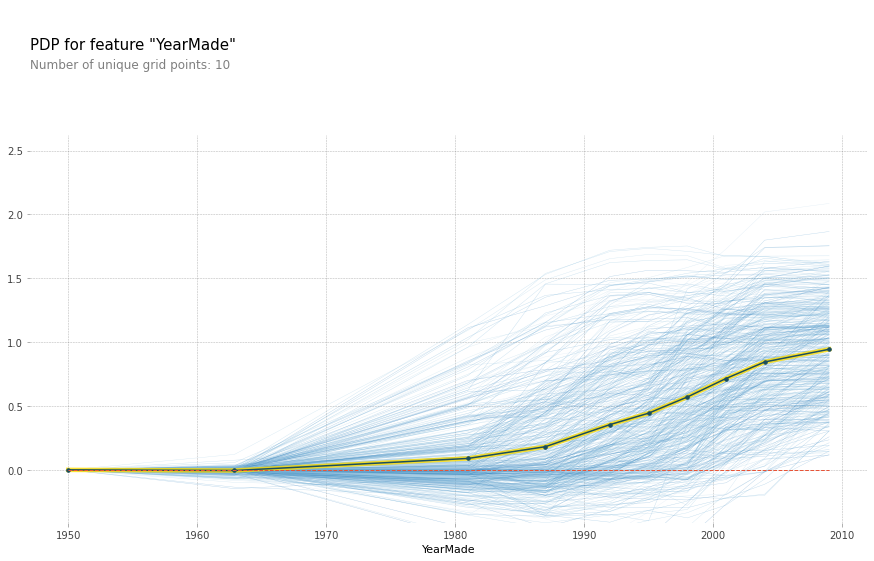

In [59]:
plot_pdp('YearMade');

**Final Model**

In [60]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12371247674439345, 0.22557499817661492, 0.9680138603254617, 0.9091280392305858, 0.9116391812670226]


**Conclusion**

With this score we would rank first in the kaggle competetion which was held.